In [1]:
from graph_cnn.model import create_model
from graph_cnn.graph import create_final_graph,cross_over
import networkx as nx
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import clear_output

2024-01-18 18:14:29.071448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 18:14:29.111565: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 18:14:29.303893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 18:14:29.303948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 18:14:29.338103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

DiGraph with 10 nodes and 39 edges


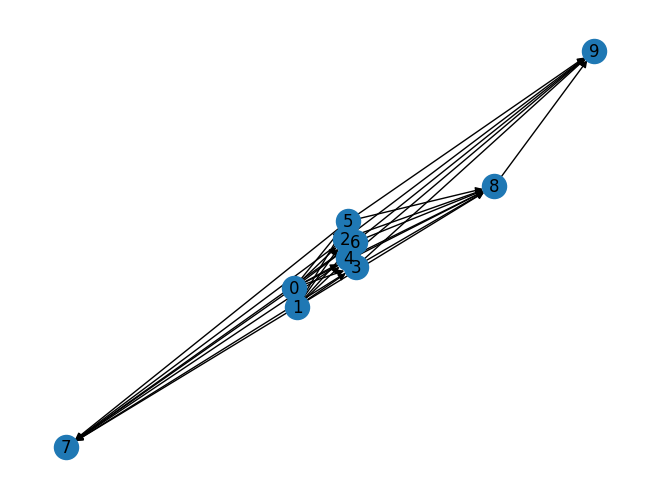

In [2]:
graph_ = create_final_graph(10,0.8)
print(graph_)
nx.draw(graph_,with_labels=True)
plt.show()
model = create_model(graph_,input_shape=(224,224,1),num_classes=10)
model.summary()

In [ ]:
train_dataset, info = tfds.load('mnist', split='train', with_info=True, as_supervised=True, shuffle_files=True)
test_dataset = tfds.load('mnist', split='test', as_supervised=True, shuffle_files=True)

# Print dataset information
print(info)

train_dataset = train_dataset.map(lambda x,y:(tf.image.resize(x,(224,224)),y)).cache().shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda x,y:(tf.image.resize(x,(224,224)),y)).cache().shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

for i,j in train_dataset:
    print(i)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
#random_flip = tf.keras.layers.RandomFlip("horizontal")(input_layer)
#random_rotation = tf.keras.layers.RandomRotation(0.2)(random_flip)
#random_zoom = tf.keras.layers.RandomZoom(0.2)(random_rotation)
#gaussian_noise = tf.keras.layers.GaussianNoise(0.3)(random_zoom)
rescaling = tf.keras.layers.Rescaling(1./255)(input_layer)
output = model(rescaling)

model2 = tf.keras.models.Model(inputs=input_layer, outputs=output)


In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.FalseNegatives(name='fn'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.SGD(0.01,0.01),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=METRICS)
model2.summary()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,min_delta=0.01, min_lr=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        y_pred =  np.array(self.model.predict(test_dataset))
        if len(y_pred.shape) == 3:
            y_pred = y_pred[0]
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

In [ ]:
tf.keras.utils.plot_model(model2, to_file="model.png", show_shapes=True, show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)

In [ ]:
'''model2=tf.keras.applications.densenet.DenseNet121(include_top=False, weights=None, input_shape=(36,36,3), pooling=None, classes=10)
model = tf.keras.models.Sequential([
    model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()'''

In [ ]:
# Predict on the test dataset
predictions = model2.predict(test_dataset)
predictions = np.array(predictions)
print(len(predictions.shape))
if len(predictions.shape) == 3:
    predictions = predictions[0]
# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
print(true_labels,predicted_labels.shape)
print(true_labels.shape,predicted_labels.shape)

# Plot the classification results
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print(cm)

In [ ]:
model2.fit(train_dataset, epochs=100, validation_data=test_dataset,callbacks=[reduce_lr,early_stop,DisplayCallback()])